# Simple synthetic

This notebook looks at the convolutional model of a seismic trace.

For a fuller example, see [Bianco, E (2004)](https://github.com/seg/tutorials-2014/blob/master/1406_Make_a_synthetic/how_to_make_synthetic.ipynb) in *The Leading Edge*.

First, the usual preliminaries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load geophysical data

We'll use `lasio` to faciliate loading curves from an LAS file.

In [2]:
import lasio
l30 = lasio.read('../data/L-30.las')

Make variables for the curves, converting to SI units on the way.

In [3]:
z = l30.curves['DEPTH:1'].data * 0.3048  # Convert to m
dt = l30.curves['DT'].data / 0.3048      # Convert to us per m
rhob = l30.curves['RHOB'].data * 1000    # Convert to kg/m3

Compute velocity and thus acoustic impedance.

In [4]:
v = 1000000 / dt
ai = v * rhob

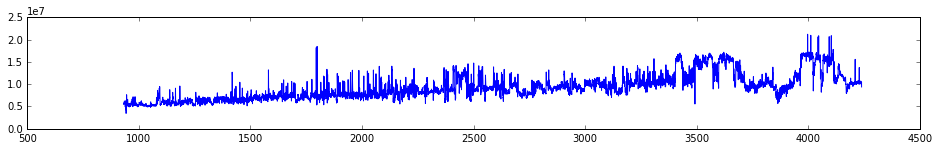

In [5]:
plt.figure(figsize=(16, 2))
plt.plot(z, ai)
plt.show()

## Depth to time conversion

The logs are in depth, but the seismic is in travel time. So we need to convert the well data to time.

We don't know the seismic time, but we can model it from the DT curve: since DT is 'elapsed time', in microseconds per metre, we can just add up all these time intervals for 'total elapsed time'. Then we can use that to 'look up' the time of a given depth.

First, get the step (depth interval) of the log values:

In [6]:
step = l30.header['Well']['STEP'].value * 0.3048  # Convert to m

Now use this to scale the DT values to 'seconds per step' (instead of µs/m).

In [7]:
scaled_dt = step * np.nan_to_num(dt) / 1e6  # Convert to seconds per step

Now do a bunch of arithmetic to find the timing of the top of the log.

In [8]:
kb = 0.3048 * l30.header['Well']['KB'].value
gl = 0.3048 * l30.header['Well']['GL'].value
start = 0.3048 * l30.header['Well']['STRT'].value

v_water = 1480
v_repl = 1800

water_layer = -gl
repl_layer = start + gl  # gl is negative

water_time = 2 * water_layer / v_water
repl_time = 2 * repl_layer / v_repl

print("Water time: {:.3f} ms\nRepl time:  {:.3f} ms".format(water_time, repl_time))

Water time: 0.186 ms
Repl time:  0.233 ms


Now finally we can compute the cumulative time elapsed on the DT log:

In [9]:
dt_time = water_time + repl_time + 2*np.cumsum(scaled_dt)

In [10]:
dt_time[-1]

2.8363125071765896

And then use this to convert the logs to a time basis:

In [26]:
dt = 0.004  # Sample interval.
maxt = 3  # Max time that we need; just needs to be longer than the log.

# Make a regular time basis: the seismic time domain.
seis_time = np.arange(0, maxt, dt) 

# Interpolate the AI log onto this basis.
ai_t = np.interp(seis_time, dt_time, ai)

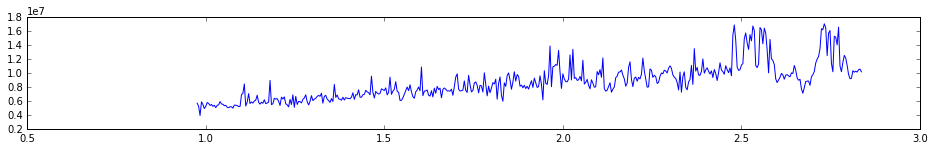

In [28]:
plt.figure(figsize=(16, 2))
plt.plot(seis_time, ai_t)
plt.show()

Now, at last, we can compute the reflection coefficients in time.

In [29]:
rc = (ai_t[1:] - ai_t[:-1]) / (ai_t[1:] + ai_t[:-1])
rc[np.isnan(rc)] = 0

Plotting these is a bit more fiddly, because we would like to show them as a sequence of spikes, rather than as a continuous curve, and matplotlib's `axvline` method wants everything in terms of fractions of the plot's dimensions, not as values in the data space.

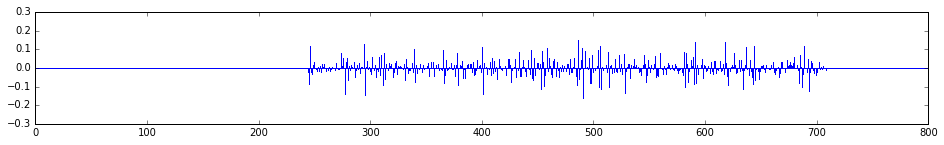

In [66]:
fig = plt.figure(figsize=(16, 2))
ax = fig.add_subplot(111)
ax.axhline()
for i, c in enumerate(rc):
    mi, ma = (0.5, 0.5+c) if c > 0 else (0.5+c, 0.5)
    ax.axvline(i, mi, ma)
ax.set_ylim(-0.3, 0.3)
plt.show()

## Impulsive wavelet

Convolve with a wavelet.

In [30]:
def ricker(f, length=0.128, dt=0.004):
    t = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y
 
f = 25
t, w = ricker(f)

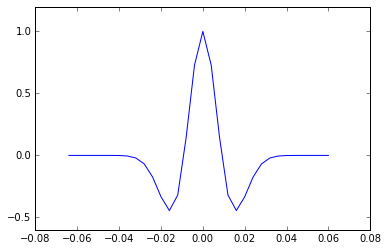

In [31]:
plt.plot(t, w)
plt.show()

In [32]:
syn = np.convolve(rc, w, mode='same')

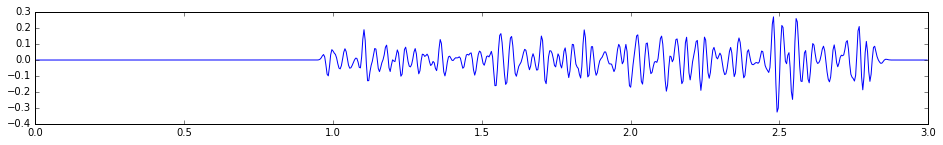

In [33]:
plt.figure(figsize=(16,2))
plt.plot(seis_time[1:], syn)
plt.show()

If we are recording with dynamite or even an airgun, this might be an acceptable model of the seismic. But if we're using Vibroseis, things get more complicated.

## Compare with the seismic

In [34]:
seismic = np.loadtxt('../data/Penobscot_xl1155.txt')

In [35]:
syn.shape

(749,)

In [36]:
# Sample index space
idx = np.arange(0, syn.size)

# The synthetic is at trace number 77
tr = 77
gain = 50

# Make a shifted version of the synthetic to overplot.
s = tr + gain*syn

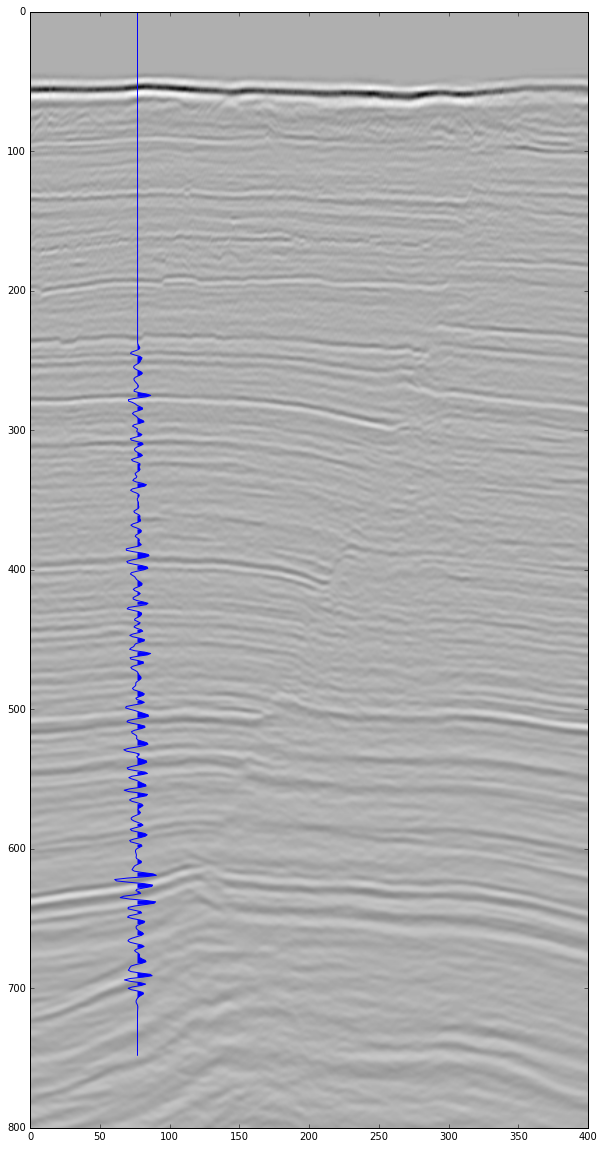

In [37]:
plt.figure(figsize=(10,20))
plt.imshow(seismic.T, cmap='Greys')
plt.plot(s, idx)
plt.fill_betweenx(idx, tr, s, where=syn>0, lw=0)
plt.xlim(0, 400)
plt.ylim(800, 0)
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>